In [38]:
%matplotlib inline

# Basic micromagnetics

In [111]:
import fenics as df
import numpy as np
import matplotlib.pyplot as plt

# Material parameters
Ms = 8.6e5  # saturation magnetisation (A/m)
alpha = 0.1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ratio
A = 1e-11 # exchange constant (J/m)

# External magentic field.
B = 0.1  # (T)
mu0 = 4 * np.pi * 1e-7  # vacuum permeability

# Zeeman field
H = Ms / 2 * df.Constant((0,1,0))
# meaningful time period is of order of nano seconds
dt = 1e-12
t_array = np.arange(0, 5e-9, dt)

############
# Simulation
############

# mesh parameters
d = 10e-9
thickness = 10e-9
nx = ny = 2
nz = 1

# create mesh
p1 = df.Point(0, 0, 0)
p2 = df.Point(d, d, thickness)
mesh = df.BoxMesh(p1, p2, nx, ny, nz)

# define function space for magnetization
V = df.VectorFunctionSpace(mesh, "CG", 1, dim=3)

# define initial M and normalise
m_init = df.Constant((1, 0, 0))
# define initial value
m = df.interpolate(m_init, V)
v = df.TestFunction(V)
volume = df.assemble(df.dot(v, df.Constant((1, 1, 1))) * df.dx).array()

def energy_density(m):
    w_Zeeman = - mu0 * Ms * df.dot(m, H)
    w_exchange = A  * df.inner(df.grad(m), df.grad(m))
    w = w_Zeeman + w_exchange
    return w

def effective_field(w, m, volume=None):
    return - 1/mu0 * df.derivative(w / Ms * df.dx, m)
    # snippet for box method: [do we need it??]
    # Heff = df.assemble(dE_dm).array()/volume

def LLG(Heff, m, alpha, gamma):
    tmp1 = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))
    # get form that can be turned into vector using 'assemble'
    dmdt = df.dot(tmp1, df.TestFunction(V)) * df.dP
    return dmdt
    
def turn_form_to_function(form, vectorspace):
    """Given a form, compute a function, by projecting the form and the
    desired solution u_sol onto test functions.
    
    This can probably be done more effeciently; review later.
    """
    V = vectorspace
    u = df.TrialFunction(V)
    v = df.TestFunction(V)
    a = df.dot(u, v) * df.dx
    L = form * v 
    u_sol = df.Function(V)
    df.solve(a==L, u_sol)
    return u_sol

def compute_dmdt(m):
    """Convenience function that does all in one go"""
    w = energy_density(m)
    Heff_form = effective_field(w, m)
    Heff_function = turn_form_to_function(Heff_form, V)
    dmdt = LLG(Heff, m, alpha, gamma)
    return dmdt

                        
w = energy_density(m)
Heff_form = effective_field(w, m, volume)
Heff = turn_form_to_function(Heff_form, V)
dmdt = LLG(Heff, m, alpha, gamma)
dmdt_vec = df.assemble(dmdt)


In [79]:
dmdt_vec.array()

array([  0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,   9.41316832e+09,  -9.41316832e+10,
         0.00000000e+00,

In [80]:
m.vector().array()

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.])

## Attempt to get time integration going
Start with non-micromagnetic example

In [114]:
def rhs_exp(y, t):
    dydt = -y   # enter ODE here
    return dydt

def Euler(f, y0, t0=0, dt=0.1, n=10):
    """f is the rhs function with signature f(y, t)"""
    ts = [t0]
    ys = [y0]
    t = t0
    y = y0
    for i in range(n):
        dydt = f(y, t)
        y = y + dydt * dt
        # store results
        t = t + dt
        ts.append(t)
        ys.append(y)
    return ts, ys

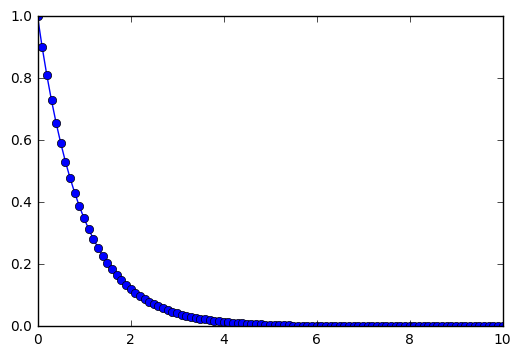

In [115]:
ts, ys = Euler(rhs_exp, y0=1, t0=0, n=100)
import pylab
pylab.plot(ts, ys, 'o-')

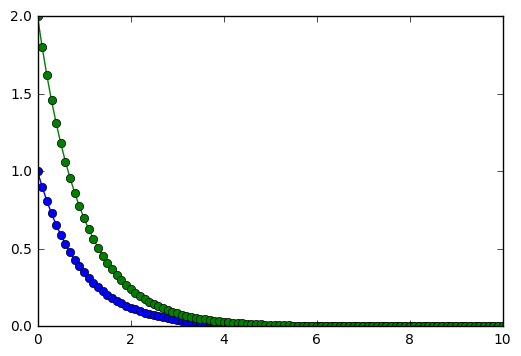

In [116]:
ts, ys = Euler(rhs_exp, y0=np.array([1, 2]), t0=0, n=100)
import pylab
pylab.plot(ts, ys, 'o-')

## Micromagnetic time integration

In [123]:
m_init = df.Constant((1, 0, 0))
m = df.interpolate(m_init, V)

def rhs_micromagnetic(m_vector_array, t):
    # convert m_vector into function
    assert isinstance(m_vector_array, np.ndarray)
    m.vector().array()[:] = m_vector_array[:]
    dmdt = compute_dmdt(m)
    # convert to vector
    dmdt_vector = df.assemble(dmdt)
    return dmdt_vector.array()

ts, ms = Euler(rhs_micromagnetic, y0=m.vector().array(), t0=0, dt=1e-11, n=50)

In [124]:
ts

[0,
 1e-11,
 2e-11,
 3e-11,
 4e-11,
 4.9999999999999995e-11,
 6e-11,
 7e-11,
 8.000000000000001e-11,
 9.000000000000001e-11,
 1.0000000000000002e-10,
 1.1000000000000002e-10,
 1.2000000000000003e-10,
 1.3000000000000002e-10,
 1.4e-10,
 1.5e-10,
 1.6e-10,
 1.6999999999999998e-10,
 1.7999999999999997e-10,
 1.8999999999999996e-10,
 1.9999999999999996e-10,
 2.0999999999999995e-10,
 2.1999999999999994e-10,
 2.2999999999999993e-10,
 2.3999999999999995e-10,
 2.4999999999999996e-10,
 2.6e-10,
 2.7e-10,
 2.8e-10,
 2.9000000000000003e-10,
 3.0000000000000005e-10,
 3.1000000000000007e-10,
 3.200000000000001e-10,
 3.300000000000001e-10,
 3.400000000000001e-10,
 3.5000000000000014e-10,
 3.6000000000000015e-10,
 3.7000000000000017e-10,
 3.800000000000002e-10,
 3.900000000000002e-10,
 4.000000000000002e-10,
 4.1000000000000024e-10,
 4.2000000000000026e-10,
 4.3000000000000027e-10,
 4.400000000000003e-10,
 4.500000000000003e-10,
 4.600000000000003e-10,
 4.700000000000003e-10,
 4.800000000000003e-10,
 

In [122]:
ms

[array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.]),
 array([ 1.        ,  0.09413168, -0.94131683,  1.        ,  0.09413168,
        -0.94131683,  1.        ,  0.09413168, -0.94131683,  1.        ,
         0.09413168, -0.94131683,  1.        ,  0.09413168, -0.94131683,
         1.        ,  0.09413168, -0.94131683,  1.        ,  0.09413168,
        -0.94131683,  1.        ,  0.09413168, -0.94131683,  1.        ,
         0.09413168, -0.94131683,  1.        ,  0.09413168, -0.94131683,
         1.        ,  0.09413168, -0.94131683,  1.        ,  0.09413168,
        -0.94131683,  1.        ,  0.09413168, -0.94131683,  1.        ,
         0.09413168, -0.94131683,  1.        ,  0.09413168, -0.94131683,
         1.        ,  0.0941316

In [110]:
%debug

> /usr/local/lib/python2.7/dist-packages/ufl/constantvalue.py(417)as_ufl()
    413     elif isinstance(expression, int):
    414         return IntValue(expression)
    415     else:
    416         raise UFLValueError("Invalid type conversion: %s can not be converted"
--> 417                             " to any UFL type." % str(expression))

ipdb> up
> /usr/local/lib/python2.7/dist-packages/ufl/operators.py(201)cross()
    199     "UFL operator: Take the cross product of *a* and *b*."
    200     a = as_ufl(a)
--> 201     b = as_ufl(b)
    202     return Cross(a, b)
    203 

ipdb> up
> <ipython-input-99-c6100bc36b1e>(58)LLG()
     56 
     57 def LLG(Heff, m, alpha, gamma):
---> 58     tmp1 = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))
     59     # get form that can be turned into vector using 'assemble'
     60     dmdt = df.dot(tmp1, df.TestFunction(V)) * df.dP

ipdb> type(m)
<class 'dolfin.functions.function.Function'>
ip

## Not working plotting

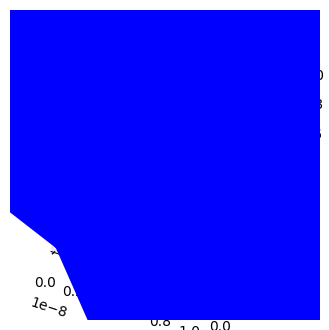

In [41]:
df.plot(Heff, interactive=True)

In [42]:
# this would be very cool, but doesn't work for Hans. Anybody got this 3d visualisation to work?
from IPython.display import HTML
HTML(df.X3DOM().html(m))

## Old notes on LLG 
from Marc Antonio and Hans, I think. See git/finmag/sandbox/cross_product

In [44]:
import dolfin as df
import time

mesh = df.UnitSquareMesh(2, 2)
print mesh
S1 = df.FunctionSpace(mesh, 'CG', 1)
S3 = df.VectorFunctionSpace(mesh, 'CG', 1, 3)
u = df.TrialFunction(S3)
v = df.TestFunction(S3)
m = df.Function(S3)  # magnetisation
Heff = df.Function(S3)  # effective field
Ms = df.Function(S1)  # saturation magnetisation
alpha = df.Function(S1)  # damping
gamma = df.Constant(1)  # gyromagnetic ratio

m.assign(df.Constant((1, 0, 0)))
Heff.assign(df.Constant((0, 0, 1)))
alpha.assign(df.Constant(1))
Ms.assign(df.Constant(1))

# just assembling it
LLG = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))
L = df.dot(LLG, df.TestFunction(S3)) * df.dP

<Mesh of topological dimension 2 (triangles) with 9 vertices and 8 cells, ordered>


In [45]:
L

Form([Integral(Dot(Sum(ComponentTensor(Product(IntValue(-1), Indexed(ComponentTensor(Product(Indexed(Cross(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 128), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=3)), 134), Cross(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 128), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=3)), 134), Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 128), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=3)), 137))), MultiIndex((Index(38),))), Division(Product(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 128), FiniteElement('Lagrange', triangle, 1)), 143), Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 146)), Sum(IntValue(1), Product(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1

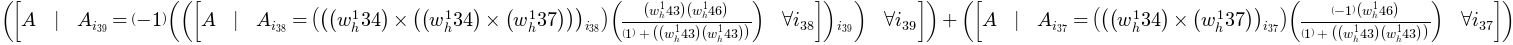

In [46]:
LLG

In [48]:
tmp = df.assemble(L)

In [50]:
tmp.array()

array([ 0. ,  0.5,  0.5,  0. ,  0.5,  0.5,  0. ,  0.5,  0.5,  0. ,  0.5,
        0.5,  0. ,  0.5,  0.5,  0. ,  0.5,  0.5,  0. ,  0.5,  0.5,  0. ,
        0.5,  0.5,  0. ,  0.5,  0.5])

In [43]:
dmdt = df.Function(S3)
start = time.time()
for i in xrange(1000):
    df.assemble(L, tensor=dmdt.vector())
stop = time.time()
print "delta = ", stop - start
print dmdt.vector().array()

NameError: name 'S3' is not defined

In [9]:
# more linear algebra, same problem... still need to assemble the cross product
# we're doing even more work than before
a = df.dot(u, v) * df.dP
A = df.assemble(a)
b = df.Function(S3)

dmdt = df.Function(S3)
start = time.time()
for i in xrange(2):
    df.assemble(L, tensor=b.vector())  # this is what should go out of the loop
    df.solve(A, dmdt.vector(), b.vector())  # some variation of this could stay in
stop = time.time()
print "delta = ", stop - start
print dmdt.vector().array()

<Mesh of topological dimension 2 (triangles) with 9 vertices and 8 cells, ordered>
delta =  0.738322019577
[ 0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5
  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5]
delta =  0.0020580291748
[ 0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5
  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5]


In [10]:
m

In [11]:
Heff

In [12]:
type(m)

dolfin.functions.function.Function

In [13]:
type(Heff)

dolfin.functions.function.Function

In [103]:
a = np.array([1, 2, 3.])

In [107]:
assert isinstance(a, np.ndarray)